In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('data.csv')

In [3]:
df.head()

,id,truck_category,distance_km,traffic_level,time_of_day,is_peak_hour,pickup_area,delivery_area,base_price_npr,accepted_price_npr,price_per_km
0,1,SMALL,10.5,Light,Afternoon,0,Gaushala,Bhaktapur,400,434.82,41.41
1,2,SMALL,7.2,Medium,Afternoon,0,Maharajgunj,Budhanilkantha,400,412.27,57.26
2,3,MEDIUM,9.8,Light,Afternoon,0,Lazimpat,Baneshwor,700,700.00,71.43
3,4,SMALL,9.3,Very Heavy,Morning,1,Chabahil,Maharajgunj,400,767.83,82.56
4,5,SMALL,2.8,Heavy,Morning,1,Baneshwor,Koteshwor,400,609.58,217.71


In [4]:
df.columns

Index(['id', 'truck_category', 'distance_km', 'traffic_level', 'time_of_day',
       'is_peak_hour', 'pickup_area', 'delivery_area', 'base_price_npr',
       'accepted_price_npr', 'price_per_km'],
      dtype='object')

In [5]:
features = ['distance_km', 'truck_category', 'traffic_level', 'time_of_day', 'is_peak_hour']


In [6]:
X = df[features].copy()

In [7]:
y = df['accepted_price_npr']


In [8]:
#encode category into numerical value like peak of the day as :1 
label_encoders = {}

categorical_cols = ['truck_category', 'traffic_level', 'time_of_day']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"  Encoded '{col}' with {len(le.classes_)} classes: {list(le.classes_)}")

  Encoded 'truck_category' with 3 classes: ['LARGE', 'MEDIUM', 'SMALL']
  Encoded 'traffic_level' with 4 classes: ['Heavy', 'Light', 'Medium', 'Very Heavy']
  Encoded 'time_of_day' with 4 classes: ['Afternoon', 'Evening', 'Morning', 'Night']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
# Create and train model
model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum depth of trees
    min_samples_split=5,   # Minimum samples to split
    min_samples_leaf=2,    # Minimum samples in leaf
    random_state=42,       # For reproducibility
    n_jobs=-1    
      )      # Use all CPU cores

In [11]:
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [12]:
#predcting on the basis of data 
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [13]:
#calaulating metrices for analysist
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("🎯 Model Performance Metrics:")
print(f"  Training R² Score:  {train_r2:.3f}")
print(f"  Testing R² Score:   {test_r2:.3f}")
print(f"  Training MAE:       NPR {train_mae:,.0f}")
print(f"  Testing MAE:        NPR {test_mae:,.0f}")
print(f"  Training RMSE:      NPR {train_rmse:,.0f}")
print(f"  Testing RMSE:       NPR {test_rmse:,.0f}")

🎯 Model Performance Metrics:
  Training R² Score:  0.992
  Testing R² Score:   0.986
  Training MAE:       NPR 25
  Testing MAE:        NPR 35
  Training RMSE:      NPR 36
  Testing RMSE:       NPR 50


In [14]:

# 8. ANALYZE FEATURE IMPORTANCE
print("\n🎯 Feature Importance Analysis:")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:20}: {row['importance']:.3f} ({row['importance']*100:.1f}%)")


🎯 Feature Importance Analysis:

Feature Importance Ranking:
  truck_category      : 0.735 (73.5%)
  is_peak_hour        : 0.238 (23.8%)
  traffic_level       : 0.019 (1.9%)
  distance_km         : 0.007 (0.7%)
  time_of_day         : 0.002 (0.2%)


In [15]:

# 9. SAVE MODEL AND ENCODERS

# Create models directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save model
joblib.dump(model, 'models/truck_pricing_model.pkl')

# Save label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')

# Save feature names
joblib.dump(features, 'models/feature_names.pkl')


['models/feature_names.pkl']

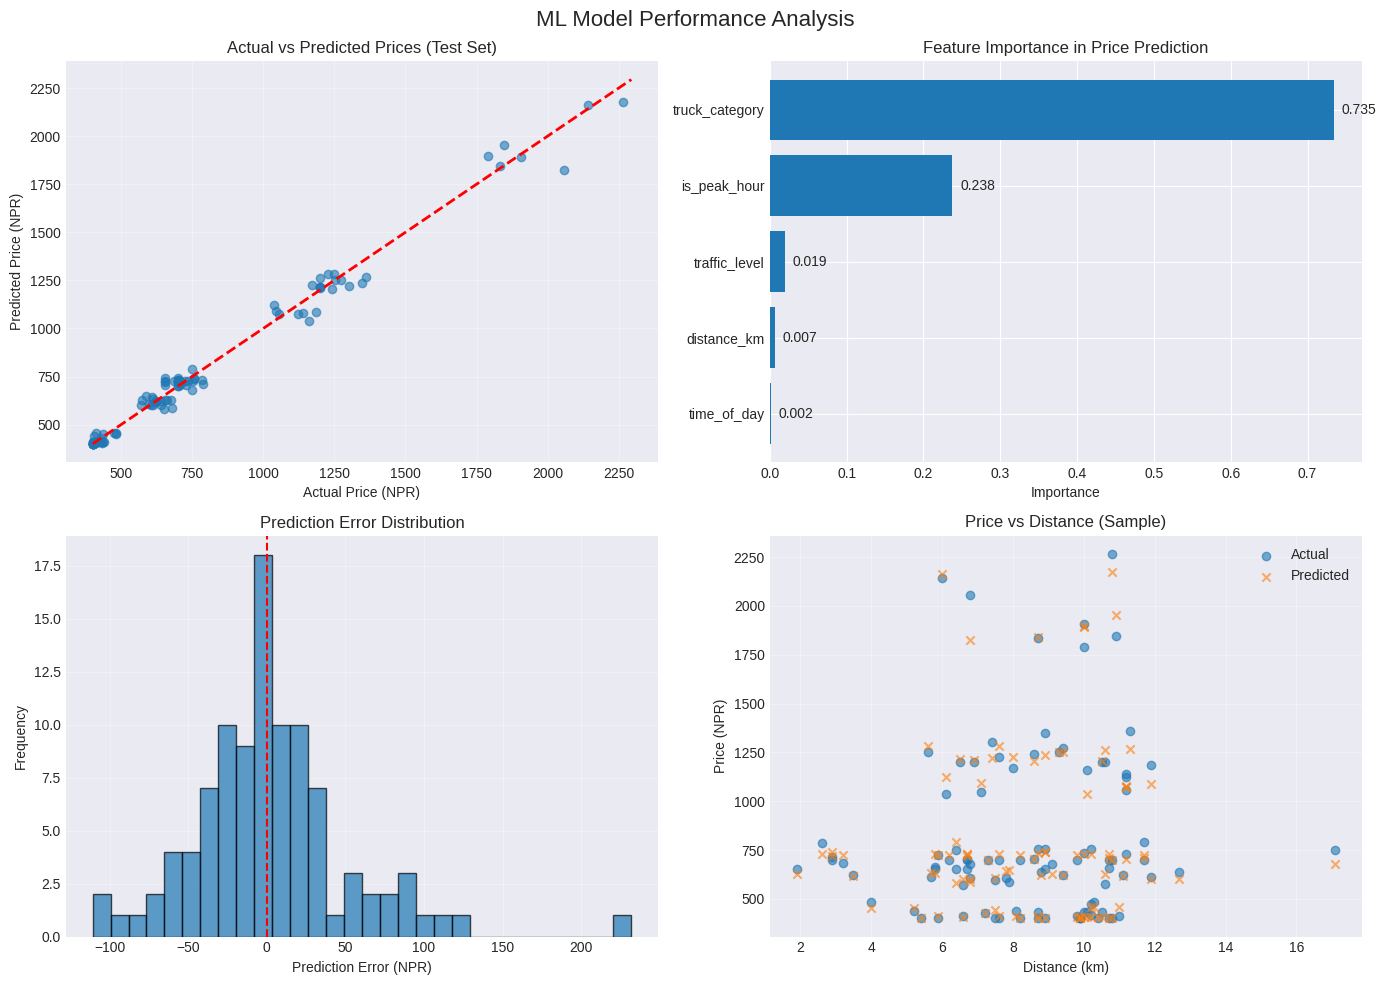

In [16]:
# 10. CREATE VISUALIZATIONS

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ML Model Performance Analysis', fontsize=16)

# 1. Actual vs Predicted (Test set)
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred, alpha=0.6)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Price (NPR)')
ax1.set_ylabel('Predicted Price (NPR)')
ax1.set_title('Actual vs Predicted Prices (Test Set)')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance
ax2 = axes[0, 1]
bars = ax2.barh(feature_importance['feature'], feature_importance['importance'])
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance in Price Prediction')
ax2.invert_yaxis()  # Highest importance at top

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', va='center')

# 3. Error Distribution
ax3 = axes[1, 0]
errors = y_test - y_test_pred
ax3.hist(errors, bins=30, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--')
ax3.set_xlabel('Prediction Error (NPR)')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Error Distribution')
ax3.grid(True, alpha=0.3)

# 4. Price vs Distance with Predictions
ax4 = axes[1, 1]
sample_idx = np.random.choice(len(X_test), min(100, len(X_test)), replace=False)
ax4.scatter(X_test.iloc[sample_idx]['distance_km'], 
           y_test.iloc[sample_idx], alpha=0.6, label='Actual')
ax4.scatter(X_test.iloc[sample_idx]['distance_km'], 
           y_test_pred[sample_idx], alpha=0.6, label='Predicted', marker='x')
ax4.set_xlabel('Distance (km)')
ax4.set_ylabel('Price (NPR)')
ax4.set_title('Price vs Distance (Sample)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')


In [17]:
# Get original feature names (before encoding)(as we before encoded each categrory to number we now decode so that it will be shown in UI)
def decode_features(encoded_features, encoders):
    """Decode encoded features back to original labels"""
    decoded = {}
    for feature, value in encoded_features.items():
        if feature in encoders:
            # Find the label for this encoded value
            le = encoders[feature]
            decoded_value = le.inverse_transform([value])[0]
            decoded[feature] = decoded_value
        else:
            decoded[feature] = value
    return decoded

TESTING

In [18]:
test_samples = [
    # Sample 1: Short trip, small truck, light traffic
    {
        'distance_km': 4.2,
        'truck_category': 'SMALL',
        'traffic_level': 'Light',
        'time_of_day': 'Afternoon',
        'is_peak_hour': 0
    },
    # Sample 2: Medium trip, medium truck, heavy traffic (peak)
    {
        'distance_km': 12.5,
        'truck_category': 'MEDIUM',
        'traffic_level': 'Heavy',
        'time_of_day': 'Evening',
        'is_peak_hour': 1
    },
    # Sample 3: Long trip, large truck, night
    {
        'distance_km': 18.7,
        'truck_category': 'LARGE',
        'traffic_level': 'Medium',
        'time_of_day': 'Night',
        'is_peak_hour': 0
    }
]

In [19]:
for i, sample in enumerate(test_samples, 1):
    # Prepare input
    input_df = pd.DataFrame([sample])
    
    # Encode categorical features
    input_encoded = input_df.copy()
    for col in categorical_cols:
        le = label_encoders[col]
        # Handle unseen categories gracefully
        try:
            input_encoded[col] = le.transform([sample[col]])[0]
        except ValueError:
            # Use most common category as fallback
            input_encoded[col] = 0
    
    # Make prediction
    predicted_price = model.predict(input_encoded[features])[0]
    
    # Calculate price range (±15%)
    lower_bound = predicted_price * 0.85
    upper_bound = predicted_price * 1.15
    
    print(f"\nSample {i}:")
    print(f"  Route: {sample['distance_km']}km | Truck: {sample['truck_category']}")
    print(f"  Traffic: {sample['traffic_level']} | Time: {sample['time_of_day']}")
    print(f"  Peak Hour: {'Yes' if sample['is_peak_hour'] else 'No'}")
    print(f"  Predicted Price: NPR {predicted_price:,.0f}")
    print(f"  Price Range: NPR {lower_bound:,.0f} - {upper_bound:,.0f}")
    
    # Compare with manual calculation
    if sample['truck_category'] == 'SMALL':
        manual_base = max(4.2 * 18, 400)
    elif sample['truck_category'] == 'MEDIUM':
        manual_base = max(12.5 * 25, 700)
    else:
        manual_base = max(18.7 * 35, 1200)
    


Sample 1:
  Route: 4.2km | Truck: SMALL
  Traffic: Light | Time: Afternoon
  Peak Hour: No
  Predicted Price: NPR 415
  Price Range: NPR 352 - 477

Sample 2:
  Route: 12.5km | Truck: MEDIUM
  Traffic: Heavy | Time: Evening
  Peak Hour: Yes
  Predicted Price: NPR 1,081
  Price Range: NPR 919 - 1,243

Sample 3:
  Route: 18.7km | Truck: LARGE
  Traffic: Medium | Time: Night
  Peak Hour: No
  Predicted Price: NPR 1,267
  Price Range: NPR 1,077 - 1,457


In [20]:
# Apply traffic factor
traffic_factors = {'Light': 1.0, 'Medium': 1.1, 'Heavy': 1.3, 'Very Heavy': 1.5}
traffic_factor = traffic_factors.get(sample['traffic_level'], 1.1)
        
if sample['is_peak_hour']:
    manual_price = manual_base * traffic_factor * 1.2
elif sample['time_of_day'] == 'Night':
    manual_price = manual_base * traffic_factor * 0.9
else:
    manual_price = manual_base * traffic_factor
        
print(f"  Manual Estimate: NPR {manual_price:,.0f}")
print(f"  Difference: {((predicted_price - manual_price)/manual_price*100):+.1f}%")



  Manual Estimate: NPR 1,188
  Difference: +6.7%
